In [1]:
from pathlib import Path
import os
import time
import json
import random as rn

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

# Metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from keras import initializers, optimizers

from bella.data_types import TargetCollection, Target
# Notebook helper methods
from bella import notebook_helper
# Models
from bella.models.tdlstm import LSTM, TDLSTM, TCLSTM
# Tokenisers
from bella.tokenisers import ark_twokenize
# Word Vectors
from bella.word_vectors import SSWE, GloveTwitterVectors, GloveCommonCrawl
# Get the data
from bella.helper import read_config
from bella.parsers import dong

Using TensorFlow backend.


In [2]:
##
#  ADD YOUR CONFIG FILE PATH HERE 
##
CONFIG_FP = Path('..', 'config.yaml')

results_folder = Path(read_config('results_folder', CONFIG_FP))
results_folder = results_folder.joinpath('TDLstm')

# Load the datasets
dong_train = dong(read_config('dong_twit_train_data', CONFIG_FP))
dong_test = dong(read_config('dong_twit_test_data', CONFIG_FP))

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
data = np.asarray(dong_train.data_dict())
sentiment = np.asarray(dong_train.sentiment_data())
for train_indexs, test_indexs in splitter.split(data, sentiment):
    train_data = data[train_indexs]
    test_data = data[test_indexs]
    
convert_to_targets = lambda data: [Target(**target) for target in data]
dong_train = TargetCollection(convert_to_targets(train_data))
dong_val = TargetCollection(convert_to_targets(test_data))

X_train = np.array(dong_train.data_dict())
y_train = np.array(dong_train.sentiment_data())
X_val = np.array(dong_val.data_dict())
y_val = np.array(dong_val.sentiment_data())
# The models do not accepts class labels that are less than 0
sent_vals = {-1: 0, 0: 1, 1: 2}
sent_vals_inv = {0: -1, 1: 0, 2: 1}
y_val = np.array([sent_vals[val] for val in y_val])
y_train = np.array([sent_vals[val] for val in y_train])

X_test = dong_test.data_dict()

In [3]:
# Get all the words from the train and test data so that we 
# can filter words from the Word Vectors so that all the 
# word vectors can be loaded into reasonable amount of memory
train_words = dong_train.word_list(ark_twokenize)
val_words = dong_val.word_list(ark_twokenize)
test_words = dong_test.word_list(ark_twokenize)
all_words = list(set(train_words + val_words + test_words))
# Load the word vectors
sswe = SSWE(filter_words=all_words)
glove_50 = GloveTwitterVectors(50, filter_words=all_words)
glove_100 = GloveTwitterVectors(100, filter_words=all_words)
glove_200 = GloveTwitterVectors(200, filter_words=all_words)
word_vectors = [sswe, glove_50, glove_100, glove_200]
n_cpus = 3

In [4]:
def evaluate_model(model_class, model_kwargs, word_vectors, result_folder, random_values):
    for word_vector in word_vectors:
        model = model_class(ark_twokenize, word_vector, **model_kwargs)
        model_result_folder = result_folder.joinpath(f'{str(model)}')
        model_result_folder.mkdir(parents=True, exist_ok=True)
        
        word_vector_fp = model_result_folder.joinpath(f'{str(model)} {str(word_vector)} '
                                                      'Repeated Results.json')
        predictions = model.evaluate_parameters(model, (X_train, y_train), (X_val, y_val), 
                                                X_test, 'reproducible', random_values, n_cpus)
        predictions = [(random_value, prediction.tolist()) 
                       for random_value, prediction in predictions]
        with word_vector_fp.open('w') as word_vector_file:
            json.dump(predictions, word_vector_file)
        

uniform_init = initializers.RandomUniform(minval=-0.003, maxval=0.003)
lstm_layer_kwargs = {'kernel_initializer' : uniform_init,
                     'recurrent_initializer' : uniform_init,
                     'bias_initializer' : uniform_init}
dense_layer_kwargs = {'kernel_initializer' : uniform_init,
                      'bias_initializer' : uniform_init}
embedding_layer_kwargs = {'embeddings_initializer' : uniform_init}
model_kwargs = {'lstm_layer_kwargs': lstm_layer_kwargs,
                'dense_layer_kwargs': dense_layer_kwargs,
                'embedding_layer_kwargs': embedding_layer_kwargs,
                'optimiser': optimizers.SGD,
                'optimiser_params': {'lr': 0.01}}


# Testing LSTM for the effect of validation set variation

In this notebook we show the effect of change in train and validation set with respect to training the 3 LSTM based models that [Tang et al.](https://www.aclweb.org/anthology/C16-1311) presented in his paper and show how close our implementation of his models come compared to the results stated in their paper. The models that they created are the following:

1. **LSTM** - Standard single layered LSTM where the hidden layer output is equal to the size of the input vector dimensions e.g. if the words vectors are 50 dimensions in size then the LSTM hidden state and output is 50 dimensions.
2. **TDLSTM** - Target Dependent LSTM. This consists of 2 LSTMs either side of the target word that the sentiment is with respect to. The Left LSTM reads words in from left to right and goes up to the last word in the target word. The right LSTM reads words right to left and goes up to the last word in the target word as well. Again the LSTM hidden state and output is the same as the dimension of the input.
3. **TCLSTM** - Target Context LSTM is the same as the TDLSTM but the input instead of being just the word vectors it reads in and word vectors are concatenated with the vector representation of the target word. If the target word is multiple words then it is the average of those word vectors.

The names of these models are direct matches to the class names that represent these models in our code base.

In [Tang et al.](https://www.aclweb.org/anthology/C16-1311) paper they never state the number of Epochs that they train for and instead of guessing the number we decided to use Early Stopping to find the optimal number of Epochs to train for.

However using Early Stopping comes with other drawbacks. As the dataset that they used for this paper (and all of the other datasets we look at) does not contain a validation set we have to create a train and validation set from the original training data. **We show in this notebook the effect of randomly splitting the training dataset into train and validation sets on the models result and how close we can reproduce the results of Tang et al.**

**NOTE** The splitting is not quiet random we use Strattified splitting therefore keeping the dataset representative with respect to the labels.


### Dataset used

The dataset we use is the same as [Tang et al.](https://www.aclweb.org/anthology/C16-1311) used in their paper which is [Dong et al](https://aclanthology.coli.uni-saarland.de/papers/P14-2009/p14-2009) Twitter dataset which is a general domain dataset.

### Word vectors used

We use the same word vectors as those shown in the paper apart from the SSWE-h and SSWE-r which we could not find, the *SSWE-u* is the equivalent to *SSWE* in our code base. We got the *SSWE* word vectors from the following [code base](https://github.com/bluemonk482/tdparse) and the Gove Twitter vectors from [here](https://nlp.stanford.edu/projects/glove/). However in our code base the word vectors will download automatically and then be saved without your user directory under the directory `.Bella`

### The experiment

Below we run each of the 3 models 30 times with different random strattified splitting and then repeat this for each word vector. **THIS TAKES A LONG TIME** therefore we have saved all of the result and if you would like to repeat the experiments set *re_write* to True

**Last Note on configurations** The pad size parameter that has to be set for each model this states how many words our LSTM model takes into accout. Setting it to -1 means that we use the length of the largest sentence (tweet) in the training set which is what was stated in the paper.

#### LSTM Evaluation

In [6]:
rn.seed(42)
random_values = [int(rn.uniform(0, 1000)) for i in range(30)] 
evaluate_model(LSTM, model_kwargs, word_vectors, results_folder, random_values)

#### TDLSTM Evaluation

In [11]:
rn.seed(42)
random_values = [int(rn.uniform(0, 1000)) for i in range(30)] 
evaluate_model(TDLSTM, model_kwargs, word_vectors, results_folder, random_values)

#### TCLSTM Evaluation

In [12]:
rn.seed(42)
random_values = [int(rn.uniform(0, 1000)) for i in range(30)] 
evaluate_model(TCLSTM, model_kwargs, word_vectors, results_folder, random_values)

## Analysis of the evaluations

Now we have all of the data saved in the respective result files we shall analysis it to see how much the results vary and how close we get to the result stated in Tang et al. paper

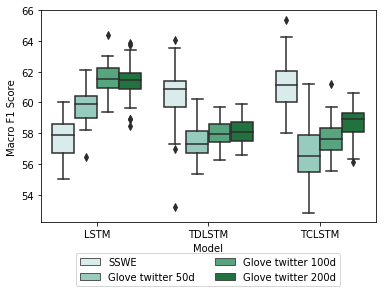

In [84]:
model_folder = {'lstm' : lstm_result_folder, 'tdlstm' : tdlstm_result_folder,
                'tclstm' : tclstm_result_folder}
model_word_vector_results = pd.DataFrame()

# Original results inputted first and then add the result we found
mean_glove_200_results = {'LSTM' : [64.7], 'TDLSTM' : [69.0], 'TCLSTM' : [69.5]}

word_vector_type = []
word_vector_results = []
model_result = []
word_vector_names = ['{}'.format(word_vector) for word_vector in word_vectors]
for model, folder in model_folder.items():
    
    for word_vector_name in word_vector_names:
        result_file = f'{str(model).upper()} {word_vector_name} Pad Size {pad_size} Repeated Results.json'
        if model == 'lstm':
            result_file = f'{str(model).upper()} {word_vector_name} Repeated Results.json'
        result_file = os.path.join(folder, result_file)
        results = notebook_helper.get_json_data(result_file, 'Dong Twitter')
        num_results = len(results)
        word_vector_results.extend(results)
        
        if word_vector_name == 'glove twitter 200d':
            mean_glove_200_results[model.upper()].append(np.array(results).mean() * 100)
        
        if word_vector_name == 'sswe':
            word_vector_name = 'SSWE'
            word_vector_type.extend([word_vector_name] * num_results)
        else:
            word_vector_type.extend([word_vector_name.capitalize()] * num_results)
        model_result.extend([model.upper()] * num_results)

model_word_vector_results['Macro F1 Score'] = np.array(word_vector_results) * 100
model_word_vector_results['Model'] =  model_result
model_word_vector_results['Word Vector'] = word_vector_type

#model_word_vector_results.columns = columns
model_word_vector_results
ax = sns.boxplot(x="Model", y="Macro F1 Score", hue="Word Vector", 
                 data=model_word_vector_results, palette='BuGn')
ax.figure.set_size_inches(6,3.9)
leg = ax.legend(loc=9, bbox_to_anchor=(0.5, -0.12), ncol=2)
ax.figure.savefig('TDLSTM dist results.png', bbox_extra_artists=(leg,), bbox_inches='tight', dpi=150)


As we can see above the results vary by quiet a lot but interestingly the LSTM method performed the best which is a different result to the original paper which states that the LSTM method performs worse than all of the other models. 

The TCLSTM method performs better than the TDLSTM for the SSWE and the 200D Glove Twitter vectors.

The order of the word vectors remains the same to the original paper when using the LSTM method. However the TD(TC)LSTM methods found the SSWE word vectors the best. We believe this could be due to the SSWE embedding having fewer OOV words than the Glove Twitter vectors even though they were originally trained on the same type of data (Twitter) they could have come from different domains. 

We can see all of the model tend to vary a lot and are therefore quiet suseptiable to change in training and validation splitting. However we can see that as the word vector size increase the amount the result deviate reduces. This result shows without specifying a Training and Validation split it is very difficult to reproduce the results of an experiment. Furthermore as you can see we never reach the values reported in the original paper thus leaving us in the dark on how they produced those results.

### Overall results

Below we show the mean values of the repeated experiments above and state these as our reported results and compared them to the original results from Tang et al paper.

In [30]:
pd.DataFrame(mean_glove_200_results, index=['Original', 'Reproduced']).round(1)

,LSTM,TCLSTM,TDLSTM
Original,64.7,69.5,69.0
Reproduced,61.4,58.7,58.2


## Error Analysis

Here we are going to look at the number of Out Of Vocabularly (OOV) words the different word vectors have for the sentence text and target text for each sample in the Dong Twitter dataset. Just as a reminder that the LSTM only takes into account the sentence text and not the target text of which the sentiment is with respect to.

For the Glove Twitter vectors as they were trained on the same text we look at them as a group rather than indivdually as each one would have the same result. Therefore below we are only going to compare Glove Twitter to SSWE vectors.

Below are some handy functions to calculate the OOV stats

In [74]:
def avg_target_oov(target_data, word_list, tokenizer=ark_twokenize, whole_target=False):
    all_oov_count = []
    target_words_list = [ark_twokenize(data['target'].lower()) for data in target_data.data()]
    for target_words in target_words_list:
        count = 0
        oov_count = 0
        for word in target_words:
            if word not in word_list:
                oov_count += 1
            count += 1
        average_oov = oov_count / count
        if whole_target:
            all_oov_count.append(math.ceil(average_oov))
        else:
            all_oov_count.append(average_oov)
    return sum(all_oov_count) / len(all_oov_count)

def average_oov(target_data, word_list, tokenizer=ark_twokenize, whole_text=False):
    all_oov_count = []
    words_list = [ark_twokenize(data['text'].lower()) for data in target_data.data()]
    for words in words_list:
        count = 0
        oov_count = 0
        for word in words:
            if word not in word_list:
                oov_count += 1
            count += 1
        average_oov = oov_count / count
        if whole_text:
            all_oov_count.append(math.ceil(average_oov))
        else:
            all_oov_count.append(average_oov)
    return sum(all_oov_count) / len(all_oov_count)


In [75]:
name_word_list = [('SSWE', sswe._word_list), ('Glove', glove_200._word_list)]
train_results = pd.DataFrame(columns=['Average Target OOV', 'Target OOV', 
                                      'Average Text OOV', 'Text OOV'],
                             index=['SSWE', 'Glove'])
for name, word_list in name_word_list:
    train_results['Average Target OOV'][name] = avg_target_oov(dong_train, word_list)
    train_results['Target OOV'][name] = avg_target_oov(dong_train, word_list, whole_target=True)
    train_results['Average Text OOV'][name] = average_oov(dong_train, word_list)
    train_results['Text OOV'][name] = average_oov(dong_train, word_list, whole_text=True)

In [78]:
rounded_train_results = (train_results * 100).astype(float).round(2)
rounded_train_results

,Average Target OOV,Target OOV,Average Text OOV,Text OOV
SSWE,1.15,2.06,4.24,47.81
Glove,1.49,2.88,9.22,78.89


In [79]:
name_word_list = [('SSWE', sswe._word_list), ('Glove', glove_200._word_list)]
test_results = pd.DataFrame(columns=['Average Target OOV', 'Target OOV', 
                                     'Average Text OOV', 'Text OOV'],
                            index=['SSWE', 'Glove'])
for name, word_list in name_word_list:
    test_results['Average Target OOV'][name] = avg_target_oov(dong_test, word_list)
    test_results['Target OOV'][name] = avg_target_oov(dong_test, word_list, whole_target=True)
    test_results['Average Text OOV'][name] = average_oov(dong_test, word_list)
    test_results['Text OOV'][name] = average_oov(dong_test, word_list, whole_text=True)

In [81]:
rounded_test_results = (test_results * 100).astype(float).round(2)
rounded_test_results

,Average Target OOV,Target OOV,Average Text OOV,Text OOV
SSWE,1.13,2.02,4.25,46.97
Glove,2.02,3.76,9.02,78.76


As we can see above the number of OOV words in the SSWE is far fewer than the Glove vectors, espically for the number of texts that have no OOV words at all. However from what we can see from the result it would appear that the TCLSTM and TDLSTM require as few OOV words in the Target text as possible to make them work better than a sentence level classifier.